In [1]:
!pwd
import os
os.chdir('..')
import bilevel
from bilevel.build_all_models import *
from bilevel.OnlineLinearExpert import *
from bilevel.OnlineTreeExpert import *
from bilevel.utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code/jupyter_scripts


In [2]:
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
# groupwise comparison of weights BATCH MODE

In [ ]:
# for ADULT inncome

In [3]:
%%time
df_adult = pd.read_csv('./data_small/adult_reconstruction.csv')

A_t_age = pd.concat([df_adult['age'] <= 35,  # young
        (df_adult['age'] > 35) & (df_adult['age'] <= 50), # middle
        df_adult['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])

A_t_edu = pd.concat([df_adult['education-num'] <= 9, df_adult['education-num'] >= 10], axis = 1, 
                keys = ['HighSchool&less', 'College&more'])

A_t_sex = pd.concat([df_adult['sex'] == 'Male', df_adult['sex'] == 'Female'], axis = 1, keys = ['Male', 'Female'])

A_t_race = pd.concat([df_adult['race'] == 'White', df_adult['race'] == 'Asian-Pac-Islander',
                      df_adult['race'] == 'Amer-Indian-Eskimo', df_adult['race'] == 'Other',
                      df_adult['race'] == 'Black'], axis = 1, keys = ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'])
A_t_adult_groups = pd.concat([A_t_age, A_t_edu, A_t_sex, A_t_race], axis=1)
A_t_adult_groups['always_on'] = True
A_t_adult_groups *= 1
A_t_adult_groups

CPU times: user 57.2 ms, sys: 17.3 ms, total: 74.5 ms
Wall time: 73.2 ms


,young,middle,old,HighSchool&less,College&more,Male,Female,White,Asian-Pac-Islander,Amer-Indian-Eskimo,Other,Black,always_on
0,0,1,0,0,1,0,1,1,0,0,0,0,1
1,1,0,0,0,1,1,0,1,0,0,0,0,1
2,1,0,0,1,0,1,0,1,0,0,0,0,1
3,0,0,1,1,0,1,0,0,1,0,0,0,1
4,1,0,0,0,1,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49526,1,0,0,0,1,1,0,1,0,0,0,0,1
49527,0,1,0,0,1,1,0,0,1,0,0,0,1
49528,1,0,0,0,1,1,0,1,0,0,0,0,1
49529,1,0,0,0,1,0,1,1,0,0,0,0,1


In [4]:
added_indicators = ['young', 'middle', 'old', 'HighSchool&less', 'College&more']
numeric_all = ['hours-per-week', 'age', 'capital-gain', 'capital-loss', 'education-num', 'income']
cat_feat =  ['workclass', 'marital-status', 'relationship', 'native-country', 'occupation', 'race', 'sex']

df_adult.drop(['education'], axis = 1, inplace=True)
df_adult_mm = numeric_scaler(df_adult, numeric_all)
df_adult_mm_oh = one_hot(df_adult_mm, cat_feat)
df_adult_mm_oh.drop(cat_feat, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_adult_mm_oh = df_adult_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_adult_mm_oh[added_indicators] = A_t_adult_groups[added_indicators]  # for a fair comparison for the baseline, we add these indicators to the dataframe too! 
df_adult_mm_oh.head()

,hours-per-week,age,capital-gain,capital-loss,education-num,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,race_Black,race_Other,race_White,sex_Female,sex_Male,young,middle,old,HighSchool&less,College&more
0,0.193878,0.315068,0.0,0.0,0.800000,0.490460,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0,1,0,0,1
1,0.397959,0.054795,0.0,0.0,0.600000,0.114053,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1
2,0.091837,0.000000,0.0,0.0,0.400000,0.024957,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,1,0
3,0.500000,0.465753,0.0,0.0,0.533333,0.389320,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1,1,0
4,0.377551,0.150685,0.0,0.0,0.800000,0.413376,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1


In [6]:
group_names_adult = list(A_t_adult_groups.columns)

In [8]:
model_lr_adult = {}
X_dat_adult = df_adult_mm_oh.drop('income', axis = 1)
y_dat_adult = df_adult_mm_oh['income']
for g_ind, gname in enumerate(group_names_adult):
    indices_g = (A_t_adult_groups[gname] == 1)
    X_dat_g = X_dat_adult[indices_g] #only has gname==1 active rows
    y_dat_g = y_dat_adult[indices_g]
    lr = Ridge()
    lr.fit(X_dat_g, y_dat_g)
    model_lr_adult[gname] = lr

In [9]:
# cross testing scores of one model on the other
N_g_adult = len(group_names_adult)
cross_test_mat_adult = np.zeros((N_g_adult,N_g_adult))

for i, gname_i in enumerate(group_names_adult):
    for j, gname_j in enumerate(group_names_adult):
        indices = (A_t_adult_groups[gname_j] == 1) # data of group j
        X_dat_j = X_dat_adult[indices]
        y_dat_j = y_dat_adult[indices]
        cross_test_mat_adult[i][j] = model_lr_adult[gname_i].score(X_dat_j, y_dat_j) # test performance of model i on data of j

<Axes: >

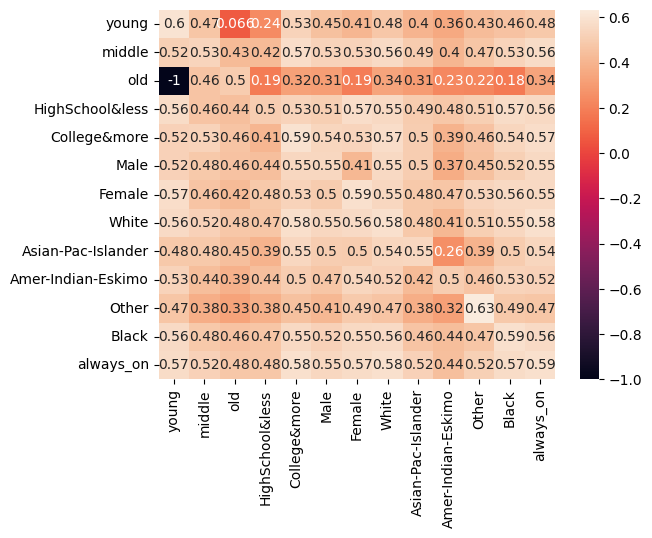

In [10]:
import seaborn as sns # for data visualization
# cross_mat, keys = cross_test_models(models_lr_dict, sex_cats, race_cats)
cross_test_mat_adult[cross_test_mat_adult < 0] = -1 # R2 score negative, means worse than a mean prediction.
sns.heatmap(cross_test_mat_adult, annot=True, xticklabels=group_names_adult, yticklabels=group_names_adult)

In [ ]:
# for medical costs

In [11]:
df_medical = pd.read_csv('./data_small/insurance.csv')

# group memberships
A_t_age = pd.concat([df_medical['age'] <= 35,  # young
        (df_medical['age'] > 35) & (df_medical['age'] <= 50), # middle
        df_medical['age'] > 50], # old
             axis = 1, keys = ['young', 'middle', 'old'])


A_t_bmi = pd.concat([df_medical['bmi'] < 18.5,  # underweight
        (df_medical['bmi'] >= 18.5) & (df_medical['bmi'] < 25), # healthy
        (df_medical['bmi'] >= 25) & (df_medical['bmi'] < 30), # overweight
        df_medical['bmi'] >= 30],  # obese
             axis = 1, keys = ['underweight', 'healthyweight', 'overweight', 'obese'])   

A_t_smoker = pd.concat([df_medical['smoker'] == 'yes', df_medical['smoker'] == 'no'], axis = 1, keys = ['smoker', 'non-smoker'])


A_t_sex = pd.concat([df_medical['sex'] == 'male', df_medical['sex'] == 'female'], axis = 1, keys = ['male', 'female'])

A_t_medical_groups = pd.concat([A_t_age, A_t_bmi, A_t_smoker, A_t_sex], axis=1)
A_t_medical_groups['always_on'] = True
A_t_medical_groups *= 1.0
print(A_t_medical_groups.sum(axis=0))

young             574.0
middle            408.0
old               356.0
underweight        20.0
healthyweight     225.0
overweight        386.0
obese             707.0
smoker            274.0
non-smoker       1064.0
male              676.0
female            662.0
always_on        1338.0
dtype: float64


In [12]:
age_groups = ['young', 'middle', 'old']
bmi_groups = ['underweight', 'healthyweight', 'overweight', 'obese']
A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison
numeric_all = ['age', 'bmi', 'children', 'charges']
cat_all = ['sex', 'smoker', 'region']
df_medical_mm = numeric_scaler(df_medical, numeric_all)
df_medical_mm_oh = one_hot(df_medical_mm, cat_all)
df_medical_mm_oh.drop(cat_all, axis = 1, inplace=True) # drop the categorics that were used to one hot encode
df_medical_mm_oh = df_medical_mm_oh * 1.0 # make bool true, false into 1.0, 0.0
df_medical_mm_oh[['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']] = A_t_medical_groups[age_groups + bmi_groups] # add this to the dataframe, for a baseline to be a fair comparison
df_medical_mm_oh.head()
added_indicators = ['age_young', 'age_middle', 'age_old', 'bmi_underweight', 'bmi_healthyweight', 'bmi_overweight', 'bmi_obese']
np.all(df_medical_mm_oh[added_indicators + ['smoker_yes', 'smoker_no', 'sex_male', 'sex_female']].to_numpy() == A_t_medical_groups.to_numpy()[:, :11]) # checks that A_t information is all included in the dataframe! no loss of group info to baseline so a fair comparison

True

In [14]:
group_names_medical = list(A_t_medical_groups.columns)

In [15]:
model_lr_medical = {}
X_dat_medical = df_medical_mm_oh.drop('charges', axis = 1)
y_dat_medical = df_medical_mm_oh['charges']
for g_ind, gname in enumerate(group_names_medical):
    indices_g = (A_t_medical_groups[gname] == 1)
    X_dat_g = X_dat_medical[indices_g] #only has gname==1 active rows
    y_dat_g = y_dat_medical[indices_g]
    lr = Ridge()
    lr.fit(X_dat_g, y_dat_g)
    model_lr_medical[gname] = lr

In [16]:
# cross testing scores of one model on the other
N_g_medical = len(group_names_medical)
cross_test_mat_med = np.zeros((N_g_medical, N_g_medical))

for i, gname_i in enumerate(group_names_medical):
    for j, gname_j in enumerate(group_names_medical):
        indices = (A_t_medical_groups[gname_j] == 1) # data of group j
        X_dat_j = X_dat_medical[indices]
        y_dat_j = y_dat_medical[indices]
        cross_test_mat_med[i][j] = model_lr_medical[gname_i].score(X_dat_j, y_dat_j) # test performance of model i on data of j

<Axes: >

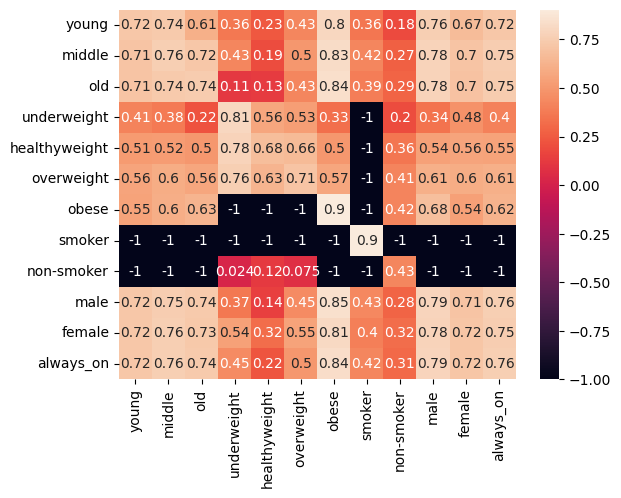

In [17]:
import seaborn as sns # for data visualization
# cross_mat, keys = cross_test_models(models_lr_dict, sex_cats, race_cats)
cross_test_mat_med[cross_test_mat_med < 0] = -1 # R2 score negative, means worse than a mean prediction.
sns.heatmap(cross_test_mat_med, annot=True, xticklabels=group_names_medical, yticklabels=group_names_medical)